In [2]:
import numpy as np
import rasterio
import glob
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

import keras
import keras.backend as K
import keras.callbacks
import keras.utils
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.layers import Input, Dense, Activation, MaxPooling2D, Conv2D, BatchNormalization
from keras.layers import Concatenate, Cropping2D, Lambda
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
plt.rcParams.update({'figure.max_open_warning': 0})

one_for_all = [
    "#FF0000",
    "#FFFFFF",
    "#FFFFFF"

]
one_for_all_cmap = matplotlib.colors.ListedColormap(one_for_all)

Using TensorFlow backend.


In [6]:
!cd ../landcover-old/web_tool/data;ls

binary				    naip_demo_model_tuned_10_epoch.h5
binary_1to4			    naip_demo_model_tuned_1_epoch.h5
naip_autoencoder.h5		    naip_demo_model_tuned_2_epoch.h5
naip_autoencoder_tuned_10_epoch.h5  naip_demo_model_tuned.h5
naip_autoencoder_tuned_1_epoch.h5   sentinel_demo_model.h5
naip_autoencoder_tuned_2_epoch.h5   sentinel_demo_model_seed_data.npz
naip_autoencoder_tuned.h5	    test_inference_ae_tuned
naip_demo_model.h5		    test_inference_demo_old
naip_demo_model_seed_data.npz	    test_inference_demo_tuned


In [5]:
def masked_categorical_crossentropy(y_true, y_pred):
    
    mask = K.all(K.equal(y_true, [1,0,0,0,0,0]), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())

    loss = K.categorical_crossentropy(y_true, y_pred) * mask

    return K.sum(loss) / K.sum(mask)

keras.losses.masked_categorical_crossentropy = masked_categorical_crossentropy



## Load model

In [12]:
# model = keras.models.load_model("../landcover-old/web_tool/data/binary/naip_autoencoder_tuned_1_epoch.h5")
model = keras.models.load_model("../landcover-old/web_tool/data/naip_autoencoder.h5")

In [21]:
model.layers[-1].output

<tf.Tensor 'conv2d_17_2/truediv:0' shape=(None, 150, 150, 64) dtype=float32>

In [25]:
model2 = keras.models.load_model("../landcover-old/web_tool/data/binary/naip_autoencoder_tuned_1_epoch.h5")
model2.layers[-1].output

<tf.Tensor 'output_conv_5/truediv:0' shape=(None, 150, 150, 3) dtype=float32>

## Load data

In [92]:
fn = rasterio.open("../landcover-old/web_tool/tiles/m_3807537_ne_18_1_20170611.mrf", "r")
width = 150
height=150

In [93]:
fn = fn.read().astype(np.float32) / 255.0
fn = np.rollaxis(fn, 0,3)

In [94]:
fn.shape

(7586, 6110, 4)

3500 350


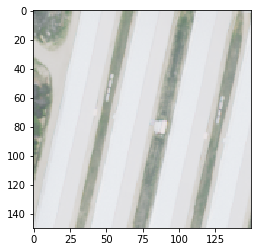

In [282]:
# x = np.random.randint(0, fn.shape[1]-width)
# y = np.random.randint(0, fn.shape[0]-height)
x = 3500
y = 350
print(x,y)
plt.imshow(fn[-75+x:x+75,-75+y:75+y,:])

In [283]:
im = fn[-75+x:x+75,-75+y:75+y,:]
im = im.reshape(1,150,150,4)

In [285]:
len(model.layers)

22

In [286]:
layer_outputs = [layer.output for layer in model.layers[:21]]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [287]:
activations = activation_model.predict(im)

In [296]:
first_layer = activations[0]
print(first_layer.shape)

(1, 150, 150, 4)


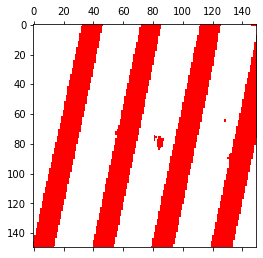

In [301]:
plt.matshow(first_layer[0,:,:,3], cmap=one_for_all_cmap)

In [302]:
layer_names = []
for layer in model.layers[:21]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

/home/jason/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

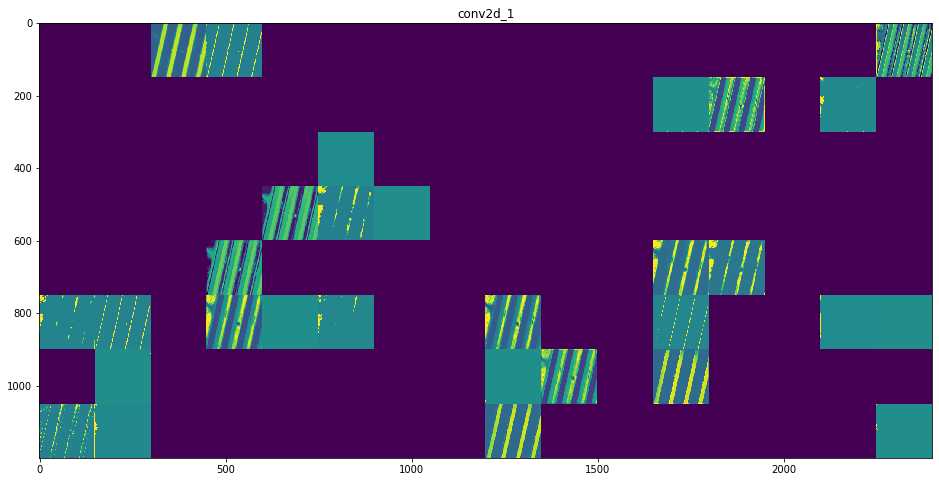

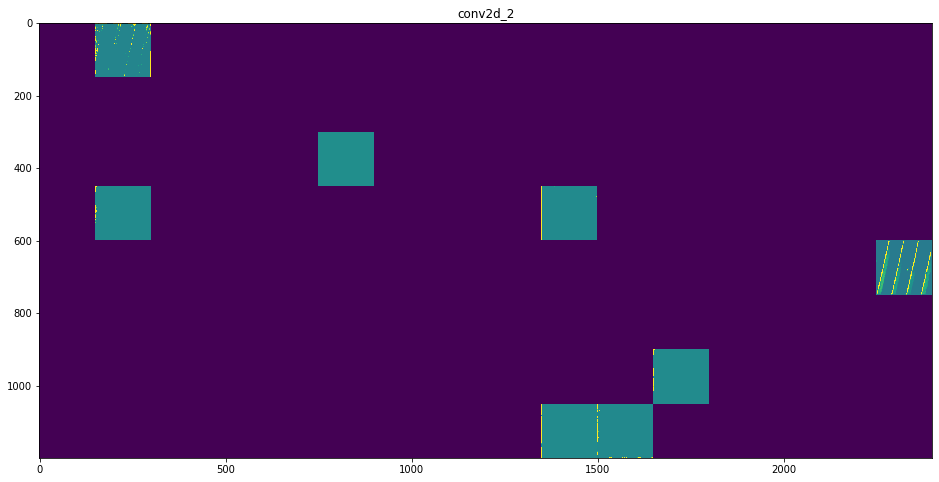

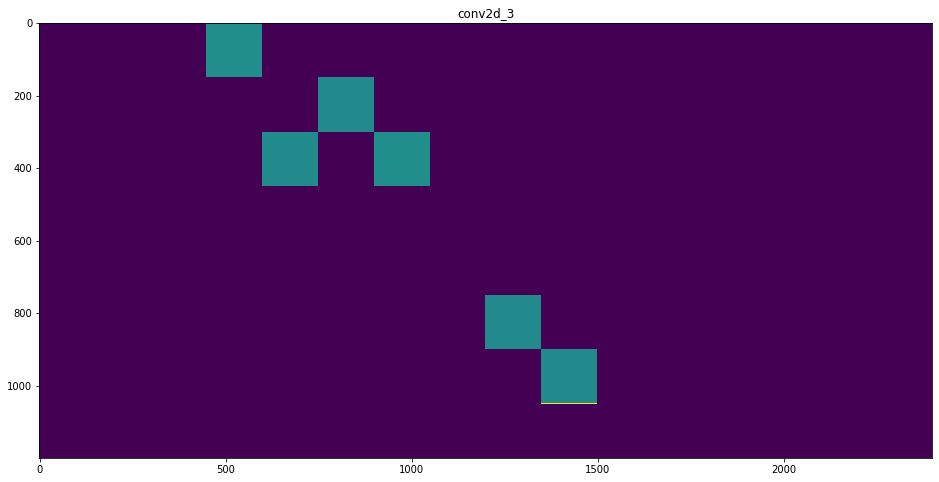

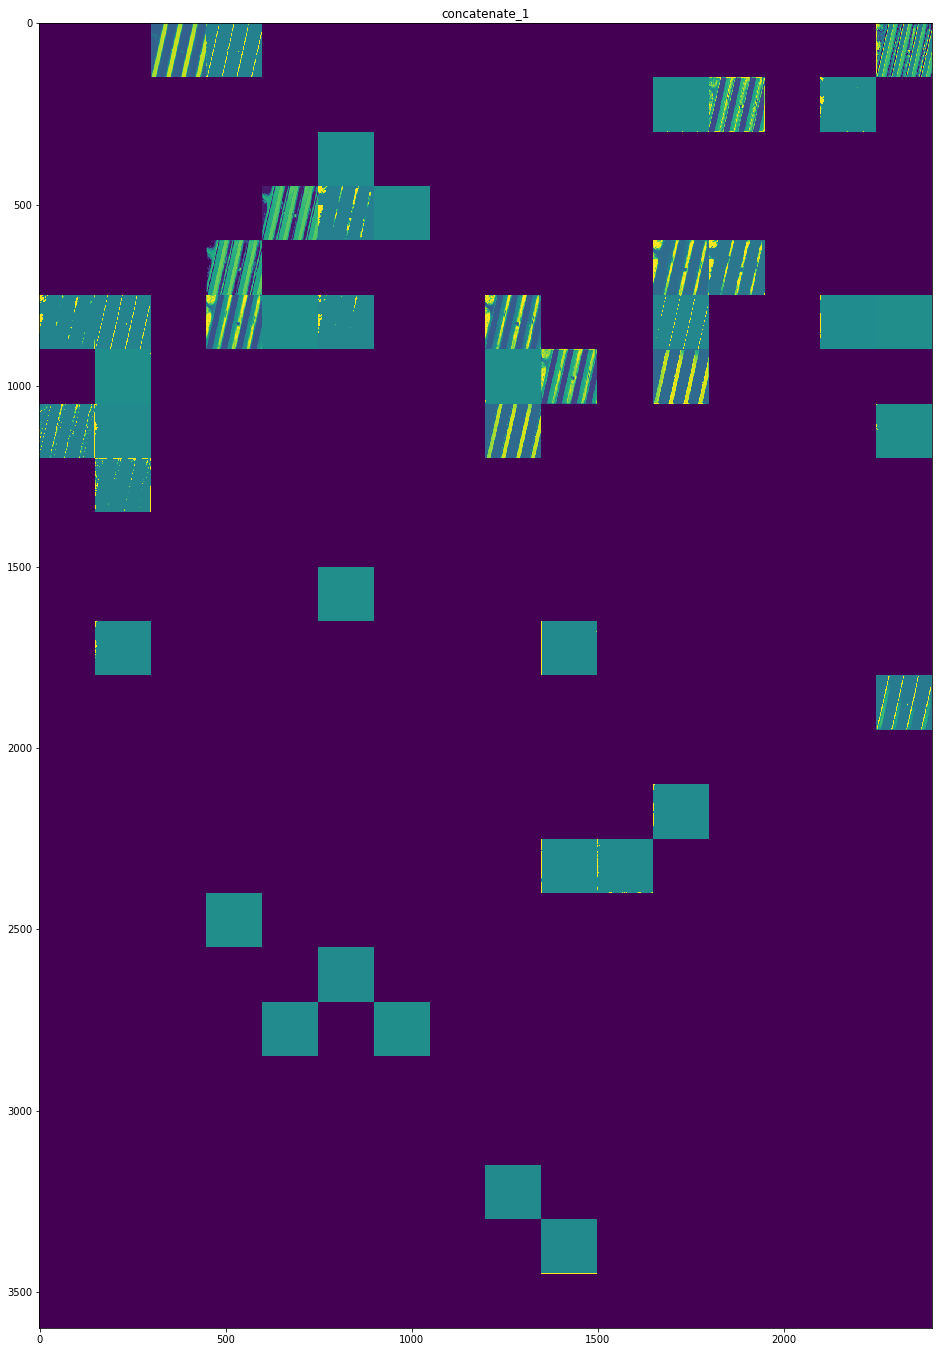

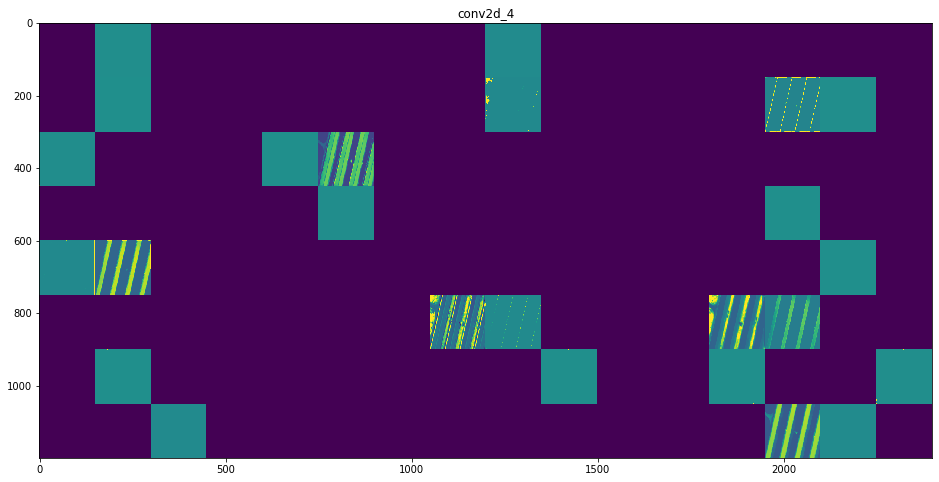

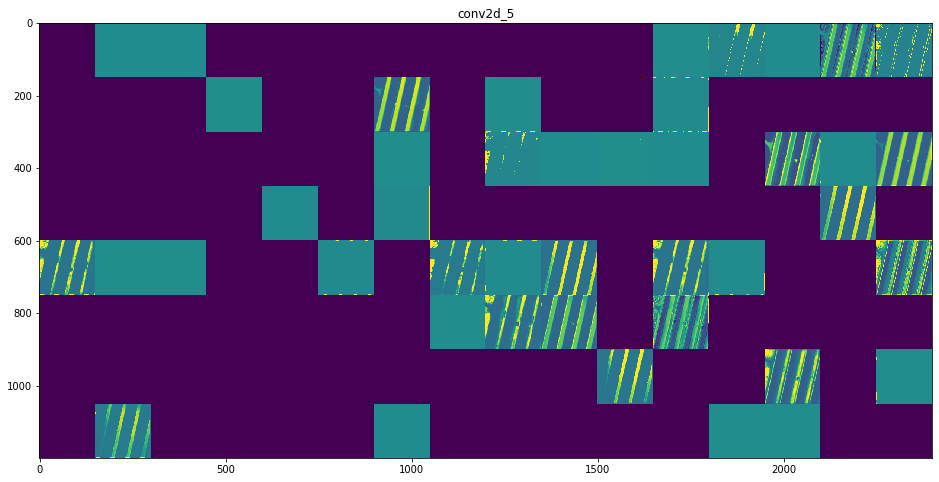

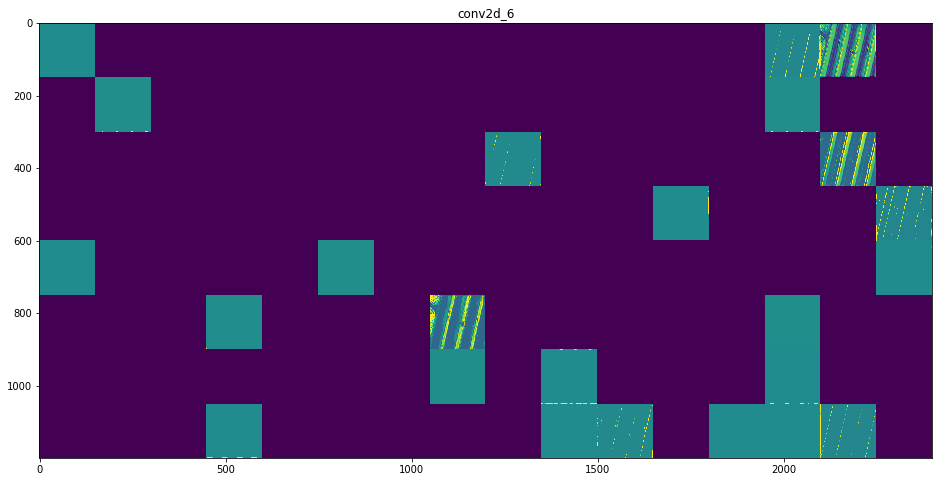

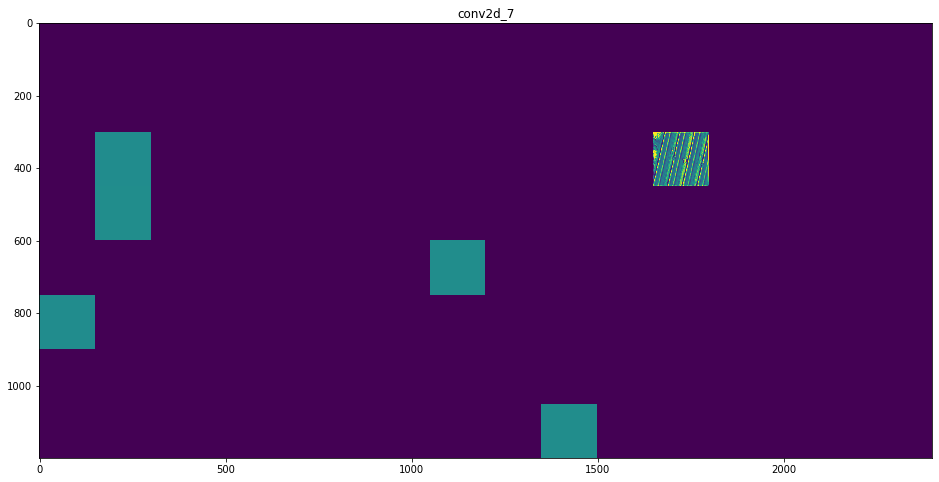

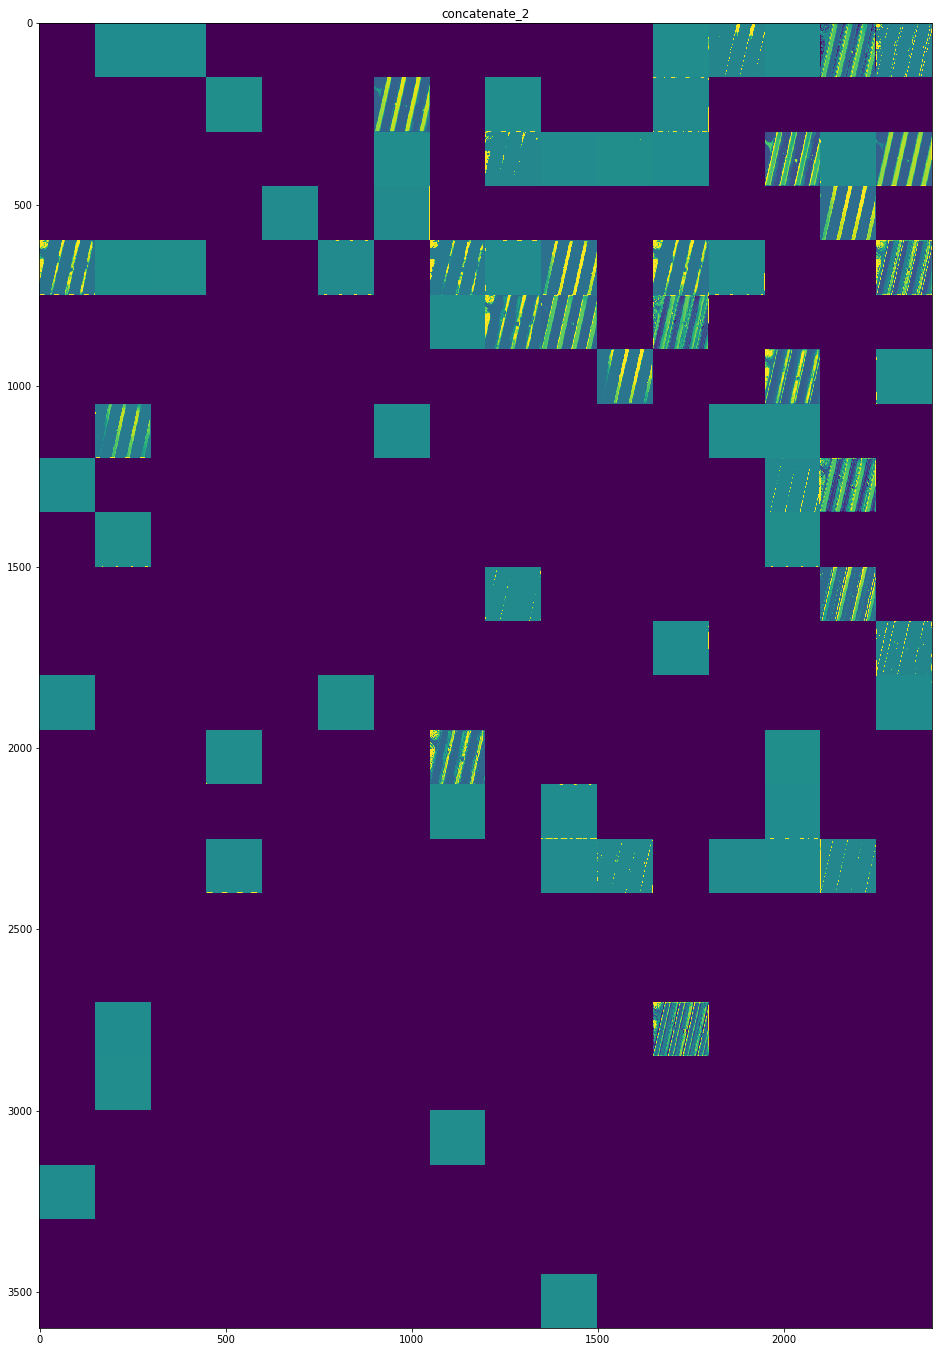

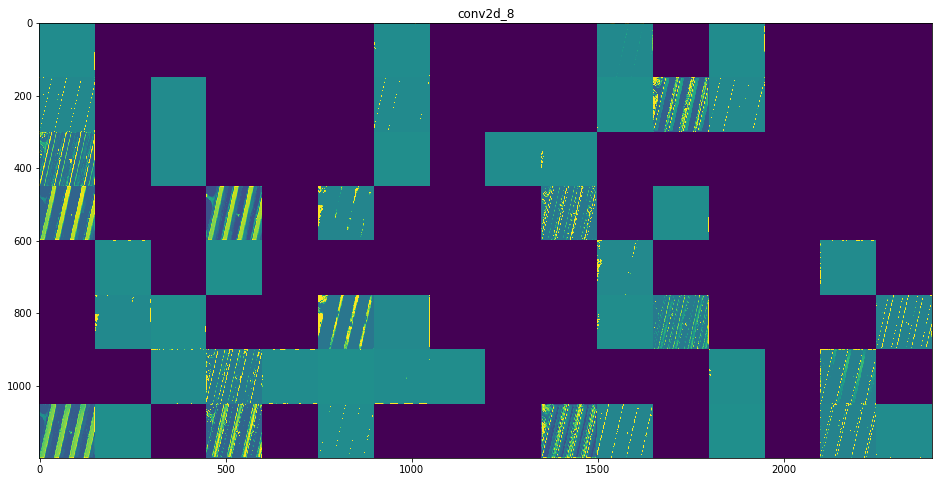

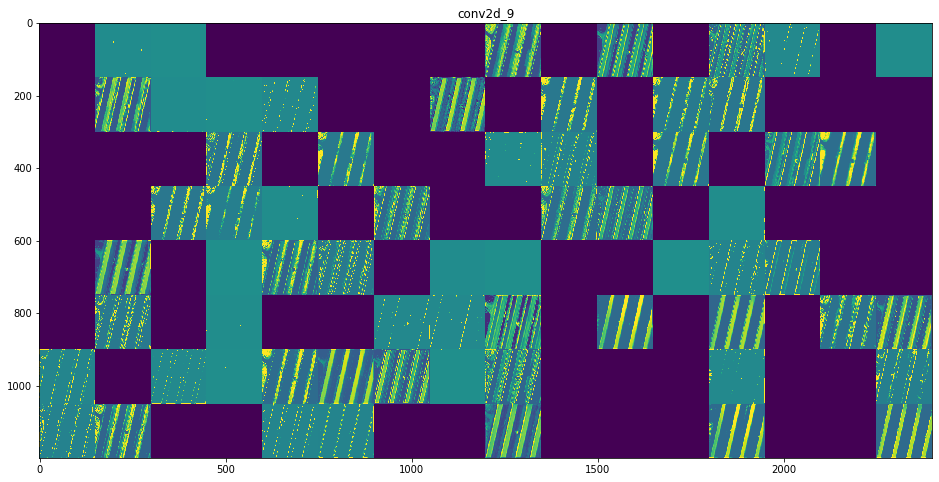

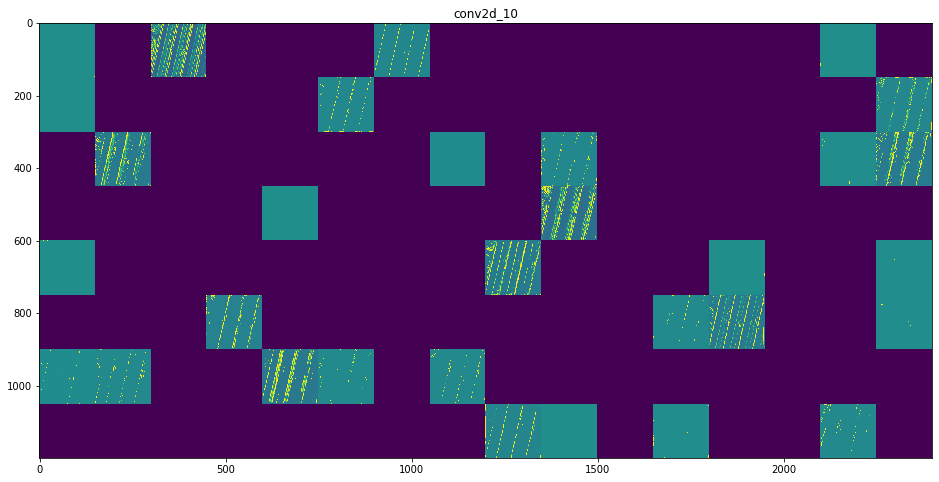

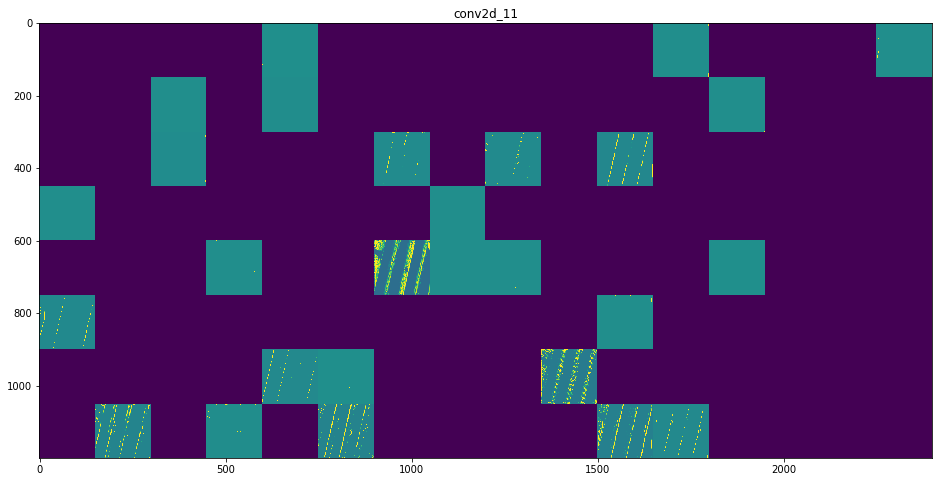

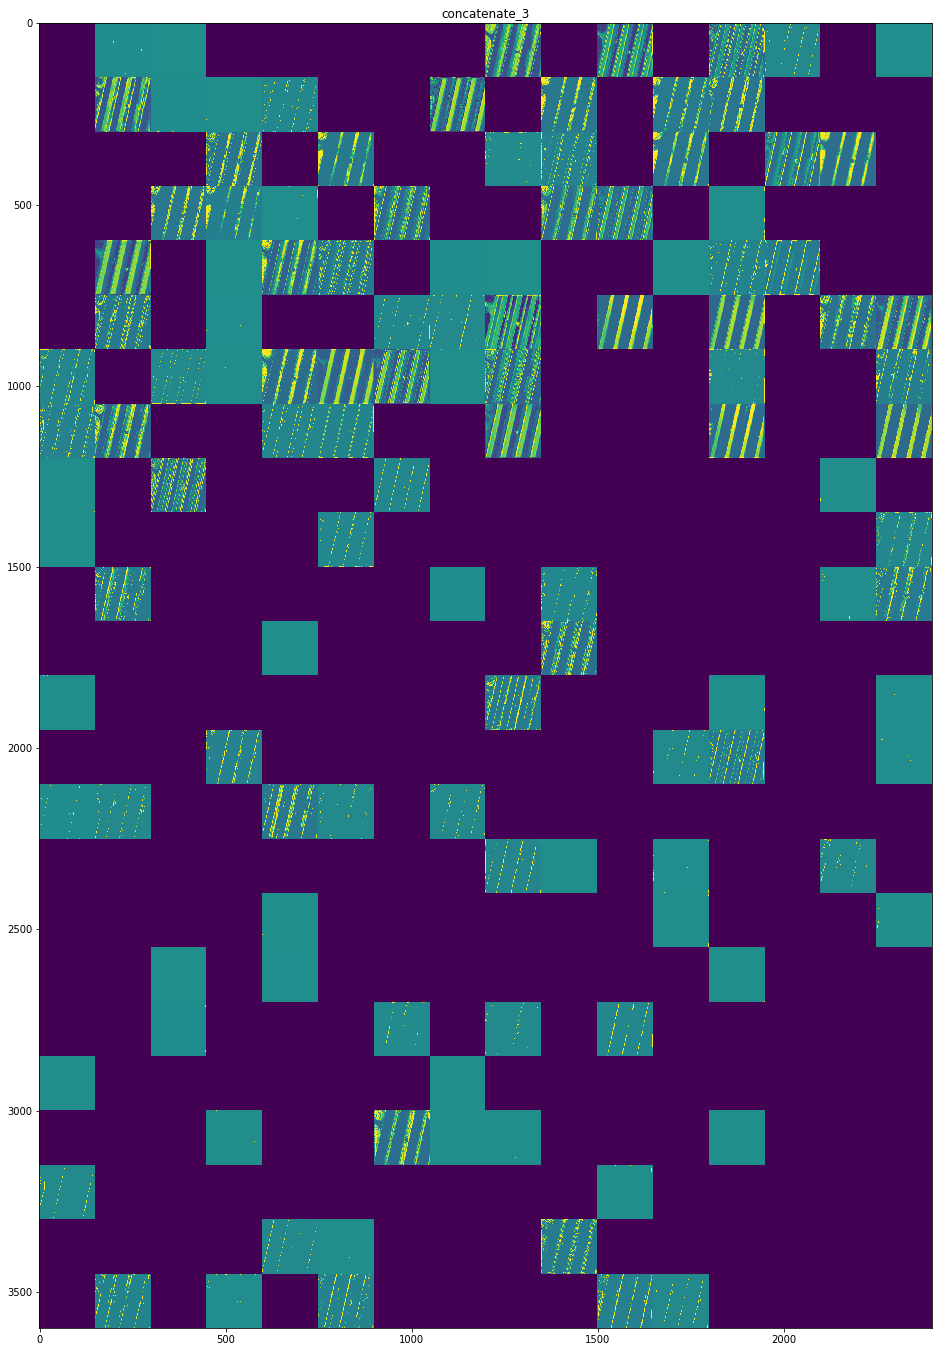

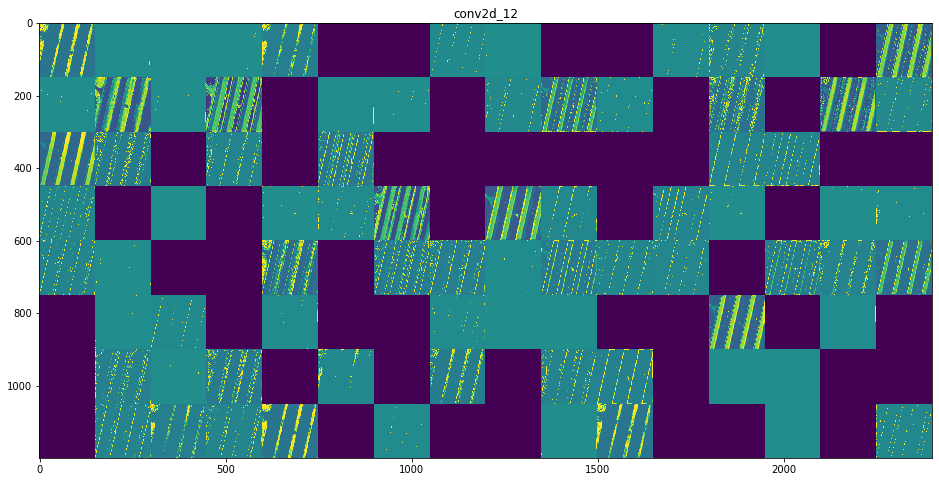

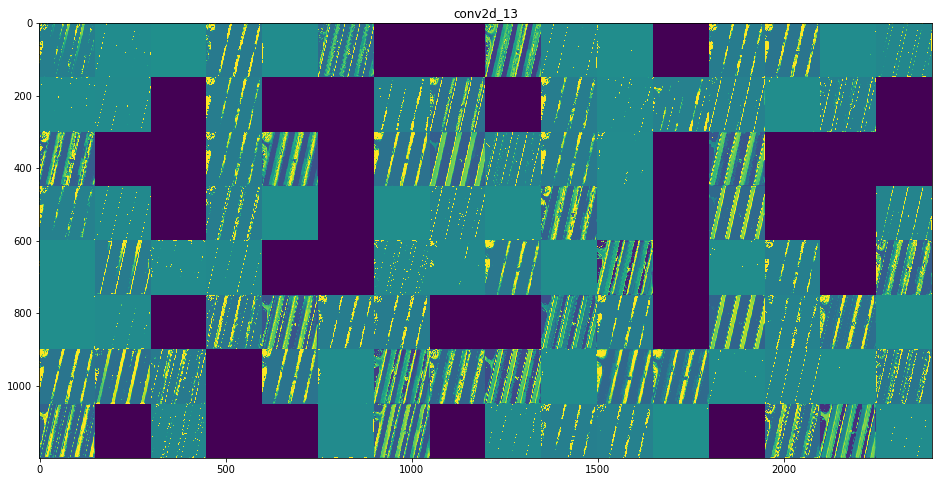

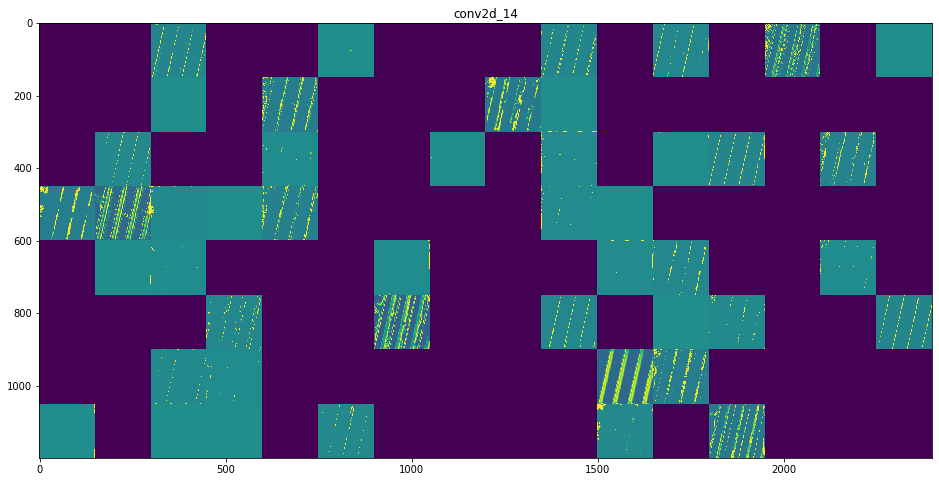

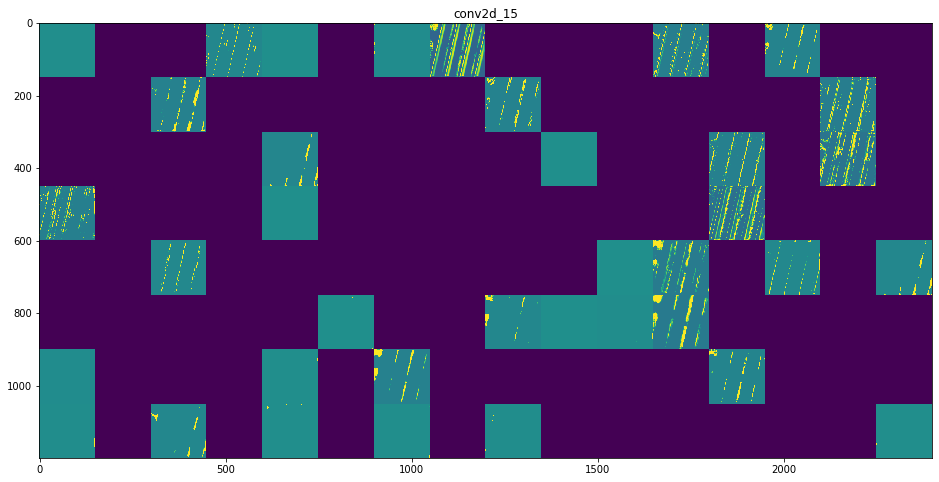

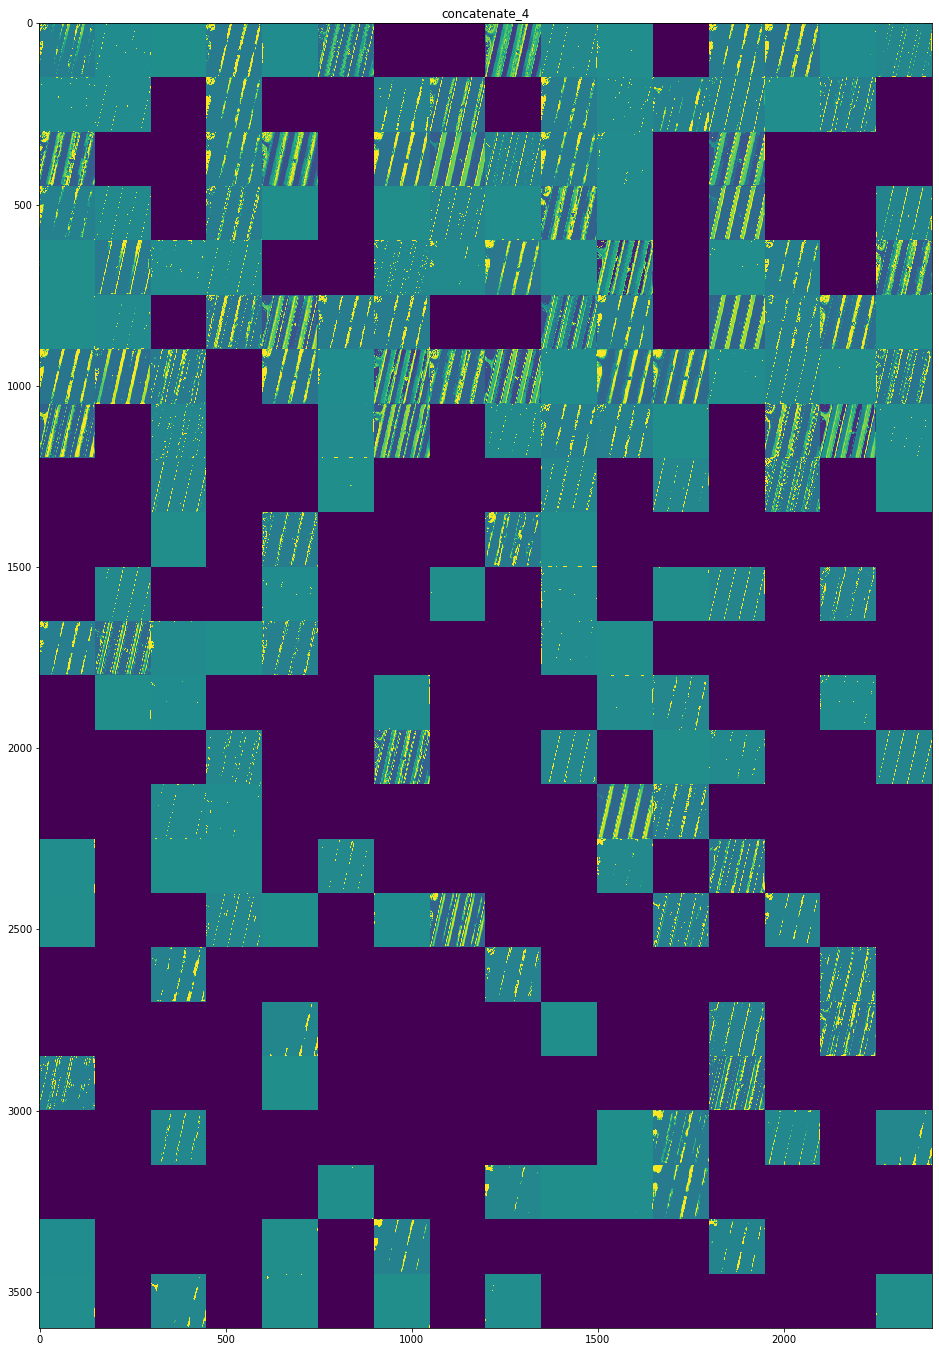

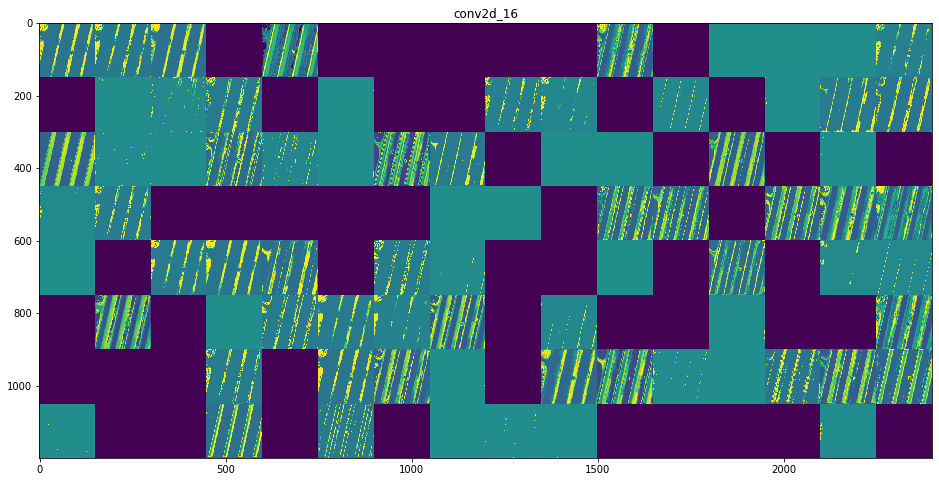

In [386]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features=layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // 16
    display_grid = np.zeros((size * n_cols, 16 * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(16):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * 16 + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto')

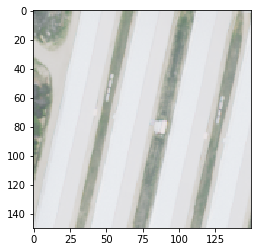

In [374]:
plt.imshow(im[0,:])

In [379]:
pred = model.predict(im)
pred = pred.reshape(150,150,3)

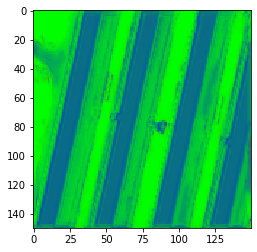

In [385]:
plt.imshow(pred, vmin=0, vmax=2, cmap=one_for_all_cmap)

## Visualize weights

In [402]:
weights = model.get_layer('conv2d_2').get_weights()

In [403]:
bias = weights[1]
weights = weights[0]

In [404]:
weights.shape

(5, 5, 4, 128)